In [764]:
import pandas as pd
import numpy as np

df_num = 5
kospi = pd.read_csv("./kospi(18~22).csv")
kospi = kospi[['회사명','종목코드', '회계년도','PBR','ROE','수익률']]
kospi['종목코드'] = kospi['종목코드'].astype(str).str.zfill(6)
kospi = kospi.replace([np.inf, -np.inf], 0)
kospi['MY'] = kospi['PBR']*1.4 + kospi['ROE']*1.1

In [765]:
PBR_list = [pd.DataFrame() for _ in range(df_num)]

for i, (year, group_df) in enumerate(kospi.groupby('회계년도')):
    sorted_df = group_df.sort_values('MY', ascending=False)
    PBR_list[i] = sorted_df.head(100)  # sorted_df를 momentum_list에 추가




ROE_list = [pd.DataFrame() for _ in range(df_num)]

for i, (year, group_df) in enumerate(kospi.groupby('회계년도')):
    sorted_df = group_df.sort_values('ROE', ascending=False)
    ROE_list[i] = sorted_df.head(0)  # sorted_df를 momentum_list에 추가




In [766]:
Port_list = [pd.DataFrame() for _ in range(df_num)]

for i in range(df_num):
    Port_list[i] = pd.concat([PBR_list[i], ROE_list[i]])

In [767]:
from dateutil.relativedelta import relativedelta
import requests as rq
from io import BytesIO
from datetime import datetime


Port_Re_list = [pd.DataFrame() for _ in range(df_num)]

adjust_price = pd.DataFrame(columns=['날짜', '종목', '종가'])
start_year = 2019


for j in range(len(Port_list)):#포트폴리오 수대로 9번 돌음.
    year = start_year+j

    for i in range(len(Port_list[j].index)):#종목 수대로 28번 돌음.
        ticker = Port_list[j]['종목코드'].iloc[i]
        name = Port_list[j]['회사명'].iloc[i]

        to_ = datetime(year, 4, 1)
        to = to_.strftime("%Y%m%d")
        fr = (to_ + relativedelta(years=-2)).strftime("%Y%m%d")

        url = f'''https://fchart.stock.naver.com/siseJson.nhn?symbol={ticker}&requestType=1
        &startTime={fr}&endTime={to}&timeframe=month'''

        data = rq.get(url).content
        data_price = pd.read_csv(BytesIO(data))


        price = data_price.iloc[:, 0:5]
        price.columns = ['날짜', '시가', '고가', '저가', '종가']
        price = price.dropna()
        price['날짜'] = price['날짜'].str.extract('(\d+)')
        price['날짜'] = pd.to_datetime(price['날짜'])
        # price['종목코드'] = ticker
        price['종목'] = name

        # price['수익률'] = price.groupby('종목')['종가'].pct_change() * 10
        columns_to_keep = ['날짜', '종목', '종가']
        price = price[columns_to_keep]

        price = price.dropna()
        price.set_index('날짜', inplace=True)

        Port_Re_list[j][price['종목'].iloc[0]] = price['종가']
        




In [768]:
from scipy.optimize import minimize


Sharpe_list = [pd.DataFrame() for _ in range(df_num)]

for i in range(df_num):

    # 주식들의 티커를 리스트로 만듭니다.
    stocks = Port_Re_list[i].columns.tolist()


    # 로그 수익률을 계산합니다.
    log_returns = np.log(Port_Re_list[i] / Port_Re_list[i].shift(1))
    # returns = Port_Re_list[i]/Port_Re_list[i].shift(1)

    # 무위험 이자율을 설정합니다. 필요에 따라 이 값을 조절할 수 있습니다.
    rf = 0.0

    # 목적 함수: 샤프 비율의 음수를 최소화합니다.
    def neg_sharpe_ratio(weights):
        portfolio_return = np.sum(log_returns.mean() * weights) * 252
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
        sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

        # return -np.sum(returns.mean() * weights) #수익률만을 기준으로 한다면

        return -sharpe_ratio

    # 제약 조건: 가중치의 합이 1이 되어야 합니다.
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})

    # 가중치의 범위: 0과 1 사이입니다.
    bounds = tuple((0, 1) for x in range(len(stocks)))

    # 초기 가중치: 모든 주식에 대해 동일하게 배분합니다.
    init_weights = [1/len(stocks) for x in range(len(stocks))]

    # 최적화 과정을 수행합니다.
    opt_weights = minimize(neg_sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=cons)

    # print("Optimal weights:", opt_weights.x)
    formatted_weights = [format(w, f".10f") for w in opt_weights.x]
    print(formatted_weights)


    Sharpe_list[i] = pd.DataFrame({'종목': stocks, '가중치': opt_weights.x})


['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000004', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000000', '0.0000000002', '0.0000000000', '0.0000000000', '0.0000000003', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000004', '0.1241463600', '0.0000000001', '0.0000000000', '0.0416545494', '0.0000000004', '0.0000000000', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000001', '0.0000000004', '0.3246394273', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000001', '0.0000000000', '0.0000000000', '0.0000000000', '0.0585477589', '0.0000000000', '0.0000000000', '0.0396390922', '0.0000000004', '0.0000000000', '0.0000000001', '0.0000000002', '0.0170270015', '0.0000000000', '0.0000000002', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000

In [769]:
#년도 별로 수익률을 구하는 코드를 짜고, sharpe ratio를 kospi와 비교
adjust_price = pd.read_csv("./adjust_price.csv")
adjust_price = adjust_price.dropna()

In [770]:
adjust_price = adjust_price.drop(adjust_price.columns[0], axis=1)

In [771]:
start_Y = 2020
i = 0
re = 1
total_re = [0, 0, 0, 0, 0]

for i in range(df_num):
    year = start_Y+i
    end_year = year+1
    # 2015년 4월부터 2016년 4월까지의 데이터를 추출합니다.
    prices = adjust_price[(adjust_price['날짜'] >= str(year)+'-04-01') & (adjust_price['날짜'] < str(end_year)+'-04-01')]

    # 데이터를 종목명에 따라 병합합니다.
    merged_data = pd.merge(Sharpe_list[i], prices, left_on='종목', right_on='종목')

    # 각 종목의 수익률에 대해 포트폴리오의 가중치를 곱합니다.
    merged_data['가중수익률'] = merged_data['가중치'] * merged_data['수익률']

    # 모든 종목에 대해 계산된 가중치를 더하여 전체 수익률을 계산합니다.
    total_return = merged_data['가중수익률'].sum()
    total_re[i] = total_return
    re *= (1+total_return)
    print(re)
  
    

0.6304344607596152
1.315036056162761
1.11681187122008
0.843614826241293
0.843614826241293


In [772]:
Sharpe_list[0].sum()

종목     삼화콘덴서공업더존비즈온엘지생활건강코웨이STX한국쉘석유한미약품한올바이오파마한미사이언스...
가중치                                                  1.0
dtype: object

[*********************100%***********************]  1 of 1 completed


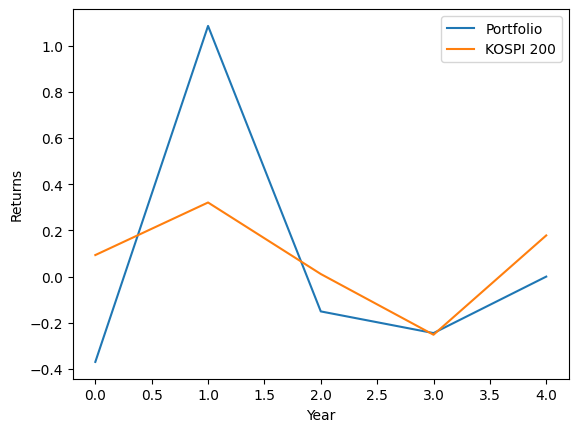

In [773]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# KOSPI200 지수를 다운로드
kospi_data = yf.download('^KS11', start='2019-01-01', end='2023-12-31')

# 연도별 첫번째 거래일과 마지막 거래일 선택
kospi_data['Year'] = kospi_data.index.year
first_days = kospi_data.groupby(kospi_data['Year']).first()
last_days = kospi_data.groupby(kospi_data['Year']).last()

# 연간 수익률 계산
kospi_returns = (last_days['Close'] - first_days['Close']) / first_days['Close']

# 주어진 포트폴리오 수익률 리스트. total_re가 이미 있을 것이라고 가정합니다.
portfolio_returns = total_re  # total_re 리스트가 있다고 가정

# 연도 리스트. 그래프를 그릴 때 필요합니다.
years = range(len(portfolio_returns))

# 그래프를 그립니다.
plt.plot(years, portfolio_returns, label='Portfolio')
plt.plot(years, kospi_returns, label='KOSPI 200')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend()

plt.show()

[*********************100%***********************]  1 of 1 completed


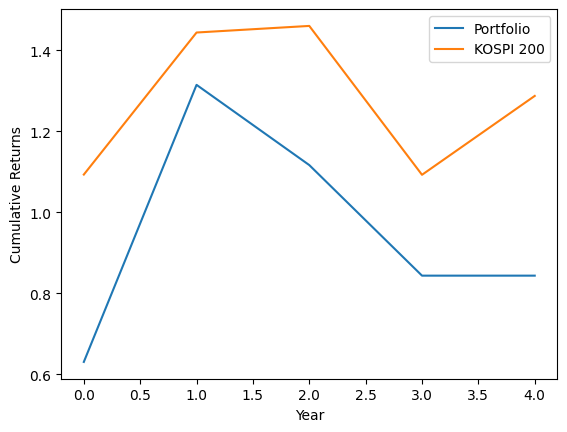

In [774]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# KOSPI200 지수를 다운로드
kospi_data = yf.download('^KS11', start='2019-01-01', end='2023-12-31')

# 연도별 첫번째 거래일과 마지막 거래일 선택
kospi_data['Year'] = kospi_data.index.year
first_days = kospi_data.groupby(kospi_data['Year']).first()
last_days = kospi_data.groupby(kospi_data['Year']).last()

# 연간 수익률 계산
kospi_returns = (last_days['Close'] - first_days['Close']) / first_days['Close'] + 1

# 연간 누적 수익률 계산
kospi_cumulative_returns = kospi_returns.cumprod()

# 주어진 포트폴리오 수익률 리스트. total_re가 이미 있을 것이라고 가정합니다.
# 연간 수익률에서 누적 수익률로 변경
portfolio_returns = list(map(lambda x: x + 1, total_re))  # total_re 리스트가 있다고 가정
portfolio_cumulative_returns = pd.Series(portfolio_returns).cumprod()

# 연도 리스트. 그래프를 그릴 때 필요합니다.
years = range(len(portfolio_returns))

# 그래프를 그립니다.
plt.plot(years, portfolio_cumulative_returns, label='Portfolio')
plt.plot(years, kospi_cumulative_returns, label='KOSPI 200')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.legend()

plt.show()

[*********************100%***********************]  1 of 1 completed


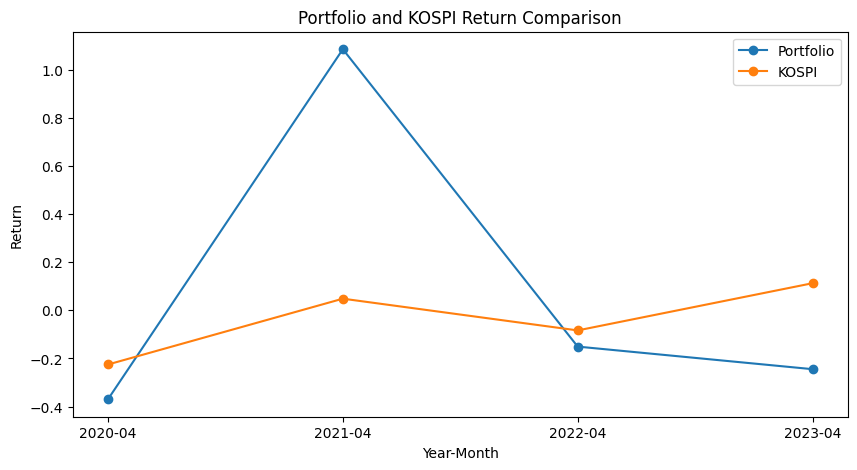

In [775]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# total_re 포트폴리오의 2020, 2021, 2022, 2023년의 4월 1일 기준 수익률
total_re = total_re[:-1] 

# KOSPI 데이터 다운로드
kospi = yf.download('^KS11', start='2020-01-01', end='2024-01-01')

# 각 연도의 4월 1일에 해당하는 날짜 리스트 생성
april_dates = [pd.Timestamp(year, 4, 1) for year in range(2020, 2024)]

# 각 날짜에 가장 가까운 이전 거래일 찾기
nearest_trading_days = [kospi.index.asof(date) for date in april_dates]

# 각 연도의 첫 거래일 추가
first_trading_days = [kospi.index[kospi.index.year == year][0] for year in range(2020, 2024)]

# 첫 거래일과 4월 1일에 가장 가까운 거래일에 해당하는 종가 찾기
kospi_selected = kospi.loc[first_trading_days + nearest_trading_days, 'Close']

# 연도별로 묶어서 수익률 계산
kospi_re = kospi_selected.groupby(kospi_selected.index.year).pct_change().dropna().tolist()

# 년도
years = [2020, 2021, 2022, 2023]  

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.plot(years, total_re, marker='o', label='Portfolio')
plt.plot(years, kospi_re, marker='o', label='KOSPI')

# x축 레이블 설정
x_labels = [f'{year}-04' for year in years]
plt.xticks(years, x_labels)


plt.xlabel('Year-Month')
plt.ylabel('Return')
plt.title('Portfolio and KOSPI Return Comparison')
plt.legend()

plt.show()

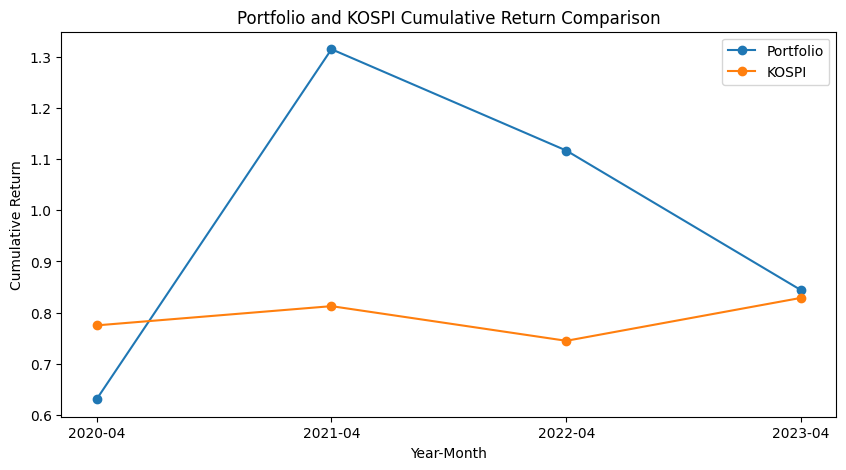

[-0.3695655392403848, 1.0859203264019932, -0.15073669198173445, -0.24462226093668604]


In [776]:
import numpy as np

# 누적 수익률 계산
cumulative_total_re = np.cumprod([i+1 for i in total_re])
cumulative_kospi_re = np.cumprod([i+1 for i in kospi_re])

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.plot(years, cumulative_total_re, marker='o', label='Portfolio')
plt.plot(years, cumulative_kospi_re, marker='o', label='KOSPI')

# x축 레이블 설정
x_labels = [f'{year}-04' for year in years]
plt.xticks(years, x_labels)


plt.xlabel('Year-Month')
plt.ylabel('Cumulative Return')
plt.title('Portfolio and KOSPI Cumulative Return Comparison')
plt.legend()

plt.show()
print(total_re)